## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 6 - Redes neurais para dados sequenciais</span>

#### Material complementar:  <span style="color:darkred">**Séries Multivariadas e Statefulness**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Utilizaremos a base de dados 3W (Petrobrás) que possui séries multivariadas medidas em poços de petróleo

In [ ]:
import numpy as np
from pandas import read_csv
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

# outros 
df1 = pd.read_csv("data/WELL-00001_20140124213136.csv")
df1.dropna(subset=['class'], inplace = True)

In [2]:
series = np.array(df1.iloc[:,2:6])

In [3]:
N = series.shape[0]
print("Tamanho da série: ", N)

Tamanho da série:  12440


## Parte 1: Preparando os dados

1. **Separação em treinamento e teste**: o treinamento sempre deve vir antes do teste no caso de dados sequenciais
2. **Normalização**: aqui utilizaremos a normalização Min-Max para 0-1
3. **Inserção de ruído opcional**: no treinamento e teste para avaliação da robustez dos modelos
4. **Formulação como aprendizado supervisionado**: adequando os arrays de forma a permitir uso nas redes neurais

In [4]:
# variaveis que definem divisao em treinamento e teste e controlam adição de ruído
porc_treinamento = 32
inserir_ruido_serie = False
inserir_ruido_teste = False
porc_ruido = 1

In [5]:
# calcula tamanhos dos dados de treinamento (n_train) e teste (n_test)
n_train = int(len(series)*(porc_treinamento/100.0))
n_test = len(series)-n_train+1

train_x = series[:n_train]
test_x = series[n_train-1:]

train_x_norm = np.zeros(train_x.shape)
test_x_norm = np.zeros(test_x.shape)

for i in range(series.shape[1]):
    vmin = train_x[:,i].min()
    vmax = train_x[:,i].max()
    train_x_norm[:,i] = (train_x[:,i] - vmin)/(vmax - vmin)
    test_x_norm[:,i] = (test_x[:,i] - vmin)/(vmax - vmin)

print("Exemplos de Treinamento: ", n_train)
print("Exemplos de Teste: ", n_test)

Exemplos de Treinamento:  3980
Exemplos de Teste:  8461


In [6]:
seed(1)
set_seed(1)

# insere ruido na serie
if (inserir_ruido_serie):
    train_x_norm = train_x_norm + np.random.randn(n_train)*(porc_ruido/100.0)

# insere ruido apenas no teste
if (inserir_ruido_teste):
    test_x_norm = test_x_norm + np.random.randn(n_test)*(porc_ruido/100.0)

## Parte 2: problema regressão com entrada multivariada

Vamos usar as séries 1, 2 e 3 para prever a série 0.

In [7]:
train_y_norm = np.array(train_x_norm[:,0], copy=True)
test_y_norm = np.array(test_x_norm[:,0], copy=True)

train_x_norm = np.delete(train_x_norm, 0, 1)
test_x_norm = np.delete(test_x_norm, 0, 1)

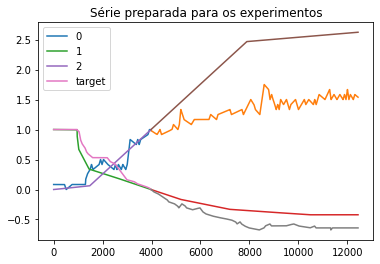

In [8]:
for i in range(train_x_norm.shape[1]):
    plt.plot(np.arange(0, n_train), train_x_norm[:,i], label=str(i))
    plt.plot(np.arange(n_train,n_train+n_test), test_x_norm[:,i])

plt.plot(np.arange(0, n_train), train_y_norm, label='target')
plt.plot(np.arange(n_train,n_train+n_test), test_y_norm)
ax = plt.title('Série preparada para os experimentos')
plt.legend()

In [9]:
test_x_norm[:4]

array([[ 9.82935154e-01,  0.00000000e+00,  1.00000000e+00],
       [ 9.82721843e-01, -1.37516098e-04,  1.00037578e+00],
       [ 9.82508532e-01, -2.75032196e-04,  1.00074460e+00],
       [ 9.82081911e-01, -4.13552061e-04,  1.00112037e+00]])

In [10]:
test_y_norm[:4]

array([ 0.        , -0.00035237, -0.00070473, -0.0010571 ])

In [11]:
# formato deve ser [samples, time steps, features]
def recurrent_array(data, target, time_steps=1):
    
    array_in = np.array(np.reshape(data, (-1, data.shape[1])), copy=True)
    array_out= np.array(np.reshape(target, (-1, 1)), copy=True)
    
    train_y_ts = array_out[time_steps:]
    train_x_ts = []
    for i in range(0, len(array_in) - time_steps):
        train_x_ts.append(array_in[i:i+time_steps])
        
    train_x_ts = np.array(train_x_ts)
    
    #rec_array = np.reshape(array, (array.shape[0], time_steps, array.shape[1]))
    return train_x_ts, train_y_ts

In [12]:
time_steps = 2

train_x_rec, train_y_rec = recurrent_array(train_x_norm, train_y_norm, time_steps=time_steps)
test_x_rec, test_y_rec = recurrent_array(test_x_norm, test_y_norm, time_steps=time_steps)

In [13]:
print('Dados de treinamento para rede recorrente')
print('Tamanho dos arrays de teste x e y')
print(train_x_rec.shape)
print(train_y_rec.shape)

print('\nPrimeiros 5 elementos de teste x e y')
print(test_x_rec[:5])
print(test_y_rec[:5])

no_features = train_x_rec.shape[2]
print('\nNúmero de features:', no_features)

Dados de treinamento para rede recorrente
Tamanho dos arrays de teste x e y
(3978, 2, 3)
(3978, 1)

Primeiros 5 elementos de teste x e y
[[[ 9.82935154e-01  0.00000000e+00  1.00000000e+00]
  [ 9.82721843e-01 -1.37516098e-04  1.00037578e+00]]

 [[ 9.82721843e-01 -1.37516098e-04  1.00037578e+00]
  [ 9.82508532e-01 -2.75032196e-04  1.00074460e+00]]

 [[ 9.82508532e-01 -2.75032196e-04  1.00074460e+00]
  [ 9.82081911e-01 -4.13552061e-04  1.00112037e+00]]

 [[ 9.82081911e-01 -4.13552061e-04  1.00112037e+00]
  [ 9.81868601e-01 -5.51068159e-04  1.00149615e+00]]

 [[ 9.81868601e-01 -5.51068159e-04  1.00149615e+00]
  [ 9.81655290e-01 -6.88584257e-04  1.00187193e+00]]]
[[-0.00070473]
 [-0.0010571 ]
 [-0.00140947]
 [-0.00176183]
 [-0.0021142 ]]

Número de features: 3


#### Rede com unidades LSTM

In [15]:
seed(1)
set_seed(1)

modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.InputLayer((None, no_features)))
modelLSTM.add(keras.layers.LSTM(16, return_sequences=True, stateful=False, 
                                activation='gelu')) # 32
modelLSTM.add(keras.layers.LSTM(32, stateful=False, activation='gelu'))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1, activation='linear'))
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 16)          1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 25
batch_size = 6 

# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 5 == 0): print("Época %04d - learning rate %.8f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# compilacao e treinamento
modelLSTM.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

# importante aqui
histLSTM = modelLSTM.fit(train_x_rec, train_y_rec,  
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], shuffle=False,
                  verbose=0)

Época 0000 - learning rate 0.00010000
Época 0005 - learning rate 0.00009901
Época 0010 - learning rate 0.00009418
Época 0015 - learning rate 0.00008958
Época 0020 - learning rate 0.00008521


Scores treinamento
MSE: 0.0020
MAE: 0.0314


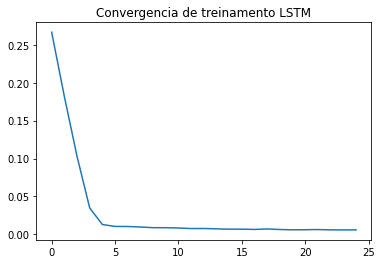

In [18]:
scores = modelLSTM.evaluate(train_x_rec, train_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.plot(histLSTM.history['loss'])
ax = plt.title('Convergencia de treinamento LSTM')

In [75]:
scoresT = modelLSTM.evaluate(test_x_rec, test_y_rec, verbose=0)
print('Scores test')
print('MSE: %.4f' % (scoresT[0]))
print('MAE: %.4f' % (scoresT[1]))

Scores test
MSE: 0.0060
MAE: 0.0696


In [19]:
# realiza predicoes com os dados de treinamento e teste
train_y_predL = modelLSTM.predict(train_x_rec)
train_y_predL = np.reshape(train_y_predL, (-1, 1))[time_steps:]

test_y_predL = modelLSTM.predict(test_x_rec)
test_y_predL = np.reshape(test_y_predL, (-1, 1))[time_steps:]

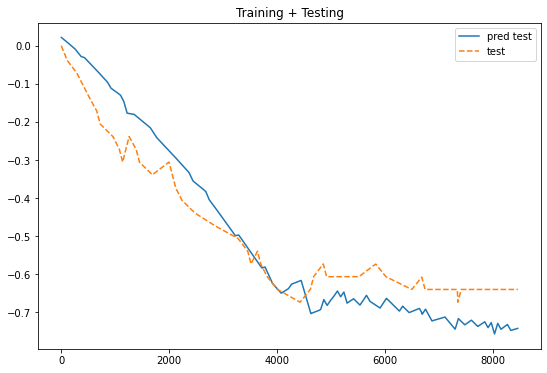

In [20]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps, len(test_y_predL)+time_steps), 
         test_y_predL, label='pred test')
plt.plot(test_y_norm, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

## Parte 3: Statefullness

Ao considerar uma unidade recorrente como "*stateful*" estamos indicando que cada seleção de batch é a continuação da anterior.

Isso só é possível se usarmos batches sequenciais e sem embaralhamento (shuffle) por isso a recomendação anterior de usar batchsize 1 para predição do próximo instante de tempo.

O *stateful* também permite que a LSTM mantenha a memória mesmo quando usamos time_step=1, desde que os batches sejam sequenciais, de forma que cada posição do batch na iteração $j$ é uma continuação da mesma posição do batch $j-1$

Além disso:
* é preciso especificar na própria arquitetura o batch size 
* o batch_size tem que ser divisível pelo total de exemplos de treinamento para não haver sobras no final da época
* LayerNormalization passa a ser necessário para evitar problemas com a magnitude do gradiente. Ao retirá-lo obtemos `nan` como valor de custo após algumas épocas

In [219]:
print(train_x_rec.shape[0])
batch_size = 2
print(train_x_rec.shape[0]/batch_size)

3978
1989.0


In [221]:
no_features = 3

seed(1)
set_seed(1)

modelLSTMs = keras.models.Sequential()
# notar a especificacao da entrada
modelLSTMs.add(keras.layers.InputLayer(
    batch_input_shape=(batch_size, train_x_rec.shape[1], train_x_rec.shape[2])))
modelLSTMs.add(keras.layers.LSTM(16, return_sequences=True, stateful=True))
modelLSTMs.add(keras.layers.Activation('gelu'))
modelLSTMs.add(keras.layers.LSTM(32, stateful=True))
modelLSTMs.add(keras.layers.LayerNormalization())
modelLSTMs.add(keras.layers.Activation('gelu'))
modelLSTMs.add(keras.layers.Dropout(0.5))
modelLSTMs.add(keras.layers.Dense(1, activation='linear'))
modelLSTMs.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (2, 2, 16)                1280      
_________________________________________________________________
activation_51 (Activation)   (2, 2, 16)                0         
_________________________________________________________________
lstm_102 (LSTM)              (2, 32)                   6272      
_________________________________________________________________
layer_normalization_42 (Laye (2, 32)                   64        
_________________________________________________________________
activation_52 (Activation)   (2, 32)                   0         
_________________________________________________________________
dropout_34 (Dropout)         (2, 32)                   0         
_________________________________________________________________
dense_51 (Dense)             (2, 1)                  

Nesse tipo de modelo, é mais indicado resetar os estados das unidades LSTM a cada época.
- caso queiramos fazer decrescer o learning rate, então também é preciso re-compilar o modelo com o valor a cada época

In [222]:
epochs = 15

# compilacao e treinamento
lr = 0.00005
histLSTMs = []
for i in range(epochs):
    lr = scheduler(i, lr)
    modelLSTMs.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            metrics=['mae'])
    hist = modelLSTMs.fit(train_x_rec, train_y_rec,  
                  batch_size=batch_size, epochs=1,
                  shuffle=False,
                  verbose=1)
    modelLSTMs.reset_states()
    
    histLSTMs.append(hist.history['loss'])

Época 0000 - learning rate 0.00005000
1989/1989 [==============================] - 9s 4ms/step - loss: 0.0161 - mae: 0.0874
Época 0005 - learning rate 0.00004950
1989/1989 [==============================] - 10s 4ms/step - loss: 0.0121 - mae: 0.0742
Época 0010 - learning rate 0.00004709
1989/1989 [==============================] - 11s 4ms/step - loss: 0.0101 - mae: 0.0673


In [223]:
scores = modelLSTMs.evaluate(train_x_rec, train_y_rec, batch_size=batch_size, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

Scores treinamento
MSE: 0.0055
MAE: 0.0580


In [171]:
scoresT = modelLSTMs.evaluate(test_x_rec, test_y_rec, 
                              batch_size=new_batch_size, verbose=0)
print('Scores test')
print('MSE: %.4f' % (scoresT[0]))
print('MAE: %.4f' % (scoresT[1]))

ValueError: in user code:

    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1323 test_function  *
        return step_function(self, iterator)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1307 run_step  **
        outputs = model.test_step(data)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1266 test_step
        y_pred = self(x, training=False)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_38: expected shape=(2, None, 3), found shape=(1, 2, 3)


Como o modelo foi criado com batch_size fixo e relacionado ao conjunto de treinamento, depois não conseguimos usá-lo para outras inferências e testes

Assim é preciso criar um novo modelo com batch_size=1 e setar os pesos do modelo treinado

In [224]:
new_batch_size = 1

# redefinir batch_size de entrada requer montar um novo modelo, 
# deve ser identico ao outro exceto pela entrada
inference_model = keras.models.Sequential()
inference_model.add(keras.layers.InputLayer(
    batch_input_shape=(new_batch_size, train_x_rec.shape[1], train_x_rec.shape[2])))
inference_model.add(keras.layers.LSTM(16, return_sequences=True, stateful=True))
inference_model.add(keras.layers.Activation('gelu'))
inference_model.add(keras.layers.LSTM(32, stateful=True))
inference_model.add(keras.layers.LayerNormalization())
inference_model.add(keras.layers.Activation('gelu'))
inference_model.add(keras.layers.Dense(1, activation='linear'))
inference_model.summary()

inference_model.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

# copia pesos do modelo anterior
pesos_modelo = modelLSTMs.get_weights()
inference_model.set_weights(pesos_modelo)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_103 (LSTM)              (1, 2, 16)                1280      
_________________________________________________________________
activation_53 (Activation)   (1, 2, 16)                0         
_________________________________________________________________
lstm_104 (LSTM)              (1, 32)                   6272      
_________________________________________________________________
layer_normalization_43 (Laye (1, 32)                   64        
_________________________________________________________________
activation_54 (Activation)   (1, 32)                   0         
_________________________________________________________________
dense_52 (Dense)             (1, 1)                    33        
Total params: 7,649
Trainable params: 7,649
Non-trainable params: 0
___________________________________________________

In [225]:
scoresT = inference_model.evaluate(test_x_rec, test_y_rec, 
                                   batch_size=new_batch_size, verbose=0)
print('Scores test')
print('MSE: %.4f' % (scoresT[0]))
print('MAE: %.4f' % (scoresT[1]))

Scores test
MSE: 0.0050
MAE: 0.0616


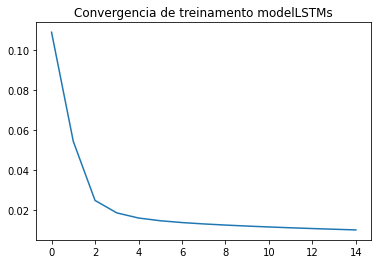

In [226]:
plt.plot(histLSTMs)
ax = plt.title('Convergencia de treinamento modelLSTMs')

In [227]:
# realiza predicoes com os dados de treinamento e teste
train_y_predS = inference_model.predict(train_x_rec, batch_size=new_batch_size)
train_y_predS = np.reshape(train_y_predS, (-1, 1))[time_steps:]

test_y_predS = inference_model.predict(test_x_rec, batch_size=new_batch_size)
test_y_predS = np.reshape(test_y_predS, (-1, 1))[time_steps:]

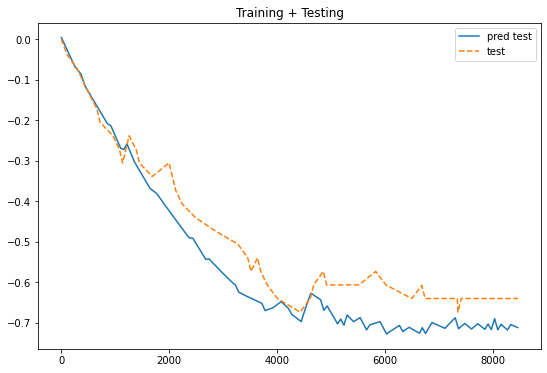

In [228]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps,len(test_y_predS)+time_steps),
         test_y_predS, label='pred test')
plt.plot(test_y_norm, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()